In [13]:
import datarobot as dr

import sklearn as sk
import pandas as pd
import numpy as np
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import yaml
import os
import pickle

In [14]:
sk.__version__

'0.23.1'

## Prep Data

Load the data into a `pandas.DataFrame`

In [15]:
data = pd.read_csv("../../data/loss_cost_demo.csv")
data_dict = pd.read_csv("../../data/var_list.csv")

In [16]:
with open("../../feature-info/feature_detail.yaml", "r") as f:
    feature_type_dict = yaml.load(f, Loader=yaml.FullLoader)

In [17]:
feature_type_dict

{'Categorical': ['DistributionChannel',
  'VehicleModel',
  'Zipcode',
  'VehicleMake',
  'ClientType',
  'MaritalStatus'],
 'Date': 'None',
 'Numeric': ['CustomerTenure',
  'DriverAge',
  'EngineCapacity',
  'NumberOfDrivers',
  'VehicleAge',
  'VehicleCostNew',
  'Zipcode_Aged_18_24',
  'Zipcode_Aged_25_29',
  'Zipcode_Aged_30_39',
  'Zipcode_Aged_40_44',
  'Zipcode_Aged_45_49',
  'Zipcode_Aged_50_59',
  'Zipcode_Aged_60',
  'Zipcode_CommuteViaCar',
  'Zipcode_PersonsPerHousehold',
  'Zipcode_VehiclesPerHousehold',
  'Zipcode_annualMileage'],
 'Offset': 'Exposure',
 'Target': 'IncurredClaims',
 'Text': 'None'}

In [18]:
numeric_features = feature_type_dict["Numeric"]
categorical_features = feature_type_dict["Categorical"]

ordinalEncoder = OrdinalEncoder()
simpleImputerCat = SimpleImputer(strategy='constant', fill_value="-9999")
simpleImputerNum = SimpleImputer(strategy='constant', fill_value= -9999 )

x_num = data[numeric_features]
x_num = simpleImputerNum.fit_transform(x_num)
x_cat = data[categorical_features]
x_cat = simpleImputerCat.fit_transform(x_cat)
x_cat = ordinalEncoder.fit_transform(x_cat)

offset = np.log(data[[feature_type_dict["Offset"]]].values)

x = np.concatenate([x_cat, x_num, offset], axis=1)

y = data[feature_type_dict["Target"]].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
offset_train = X_train[:, -1]
offset_test = X_test[:, -1]
X_train = X_train[:, 0:-1]
X_test = X_test[:, 0:-1]


In [19]:
simpleImputerNum.n_features_in_

17

In [20]:
model = lgb.LGBMRegressor(objective="tweedie", learning_rate= 0.08)

fit = model.fit(X_train, y_train, init_score = offset_train, eval_init_score = [offset_test], eval_set=(X_test, y_test), verbose=False)

/Users/timothy.whittaker/notebook/lib/python3.7/site-packages/lightgbm/basic.py:253: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


In [21]:
yhat = np.exp(fit.predict(X_test, raw_score = True) + offset_test)

In [22]:
check = pd.DataFrame([y_test, yhat]).T
check.columns = ["y", "yhat"]
check["rank"] = np.ceil(check["yhat"].rank(pct=True)*10)

<AxesSubplot:xlabel='rank'>

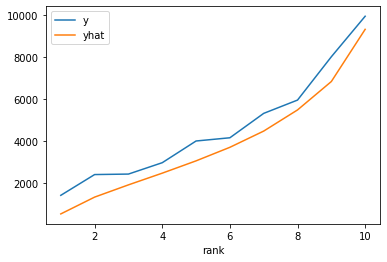

In [23]:
%matplotlib inline
check.groupby("rank").mean().plot()

In [24]:
from joblib import dump, load
with open('../../model-objects/ordinalEncoder.joblib', "wb") as f:
    dump(ordinalEncoder, f) 
with open('../../model-objects/simpleImputerCat.joblib', "wb") as f:
    dump(simpleImputerCat, f) 
with open('../../model-objects/simpleImputerNum.joblib', "wb") as f:
    dump(simpleImputerNum, f) 
with open('../../model-objects/lgbm.joblib', "wb") as f:
    dump(fit, f)